# Parsing the Dataset

### Read Dataset from Hugging Face

In [1]:
from datasets import load_dataset # Import dataset import function for hugging face
dataset = load_dataset("surrey-nlp/PLOD-CW") # import the coursework dataset from

#### Dataset Manipulation Instructions

**Dataset** splits into 3 distinct parts:
- train
- validation
- test

To access each call `dataset[set_name]`

For instance `dataset["train"]`

Each set has 3 **features**:
- tokens (words that form a sentance, split into a list)
- pos_tags (part of speech tags)
- ner_tags (name entity recognition tags)

To access each features, call `dataset[set_name][feature_name]`

For instance `dataset["train"]["tokens"]`

First element `dataset["train"]["tokens"][0]`

### Import Libraries

In [2]:
import nltk
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn_crfsuite as crfsuite
from sklearn_crfsuite import metrics

### Parse data into objects

In [3]:
train_tokens = dataset["train"]["tokens"]
train_pos_tags = dataset["train"]["pos_tags"]
train_ner_tags = dataset["train"]["ner_tags"]

validation_tokens = dataset["validation"]["tokens"]
validation_pos_tags = dataset["validation"]["pos_tags"]
validation_ner_tags = dataset["validation"]["ner_tags"]

test_tokens = dataset["test"]["tokens"]
test_pos_tags = dataset["test"]["pos_tags"]
test_ner_tags = dataset["test"]["ner_tags"]

class DataItem:
    def __init__(self, tokens, pos, ner):
        self.tokens:list[str] = tokens
        self.pos:list[str] = pos
        self.ner:list[str] = ner

    def get_as_tuple(self) -> tuple:
        return (self.tokens, self.pos, self.ner)
    
    def get_as_tuple_list(self) -> list[tuple]:
        tuple_list = []
        for idx in range(len(self.tokens)-1):
            tuple_list.append((self.tokens[idx], self.pos[idx], self.ner[idx]))
        return tuple_list
    
train_data:list[DataItem] = []
for idx in range(len(train_tokens)):
    train_data.append(DataItem(train_tokens[idx], train_pos_tags[idx], train_ner_tags[idx]))

validation_data:list[DataItem] = []
for idx in range(len(validation_tokens)):
    train_data.append(DataItem(validation_tokens[idx], validation_pos_tags[idx], validation_ner_tags[idx]))

test_data:list[DataItem] = []
for idx in range(len(test_tokens)):
    train_data.append(DataItem(test_tokens[idx], test_pos_tags[idx], test_ner_tags[idx]))

### Create tuples of token, pos and ner

In [4]:
def create_data_sents(data:list[DataItem]) -> list[tuple]:
    sent_list:list[tuple] = []
    for data_obj in data:
        sent_list.append(data_obj.get_as_tuple_list())
    return sent_list

train_sents:list[tuple] = create_data_sents(train_data)
validation_sents:list[tuple] = create_data_sents(validation_data)
test_sents:list[tuple] = create_data_sents(test_data)


## Training

In [79]:
# def read_clusters(cluster_file):
#     word2cluster = {}
#     with open(cluster_file) as i:
#         for line in i:
#             word, cluster = line.strip().split('\t')
#             word2cluster[word] = cluster
#     return word2cluster


# def word2features(sent, i, word2cluster):
#     word = sent[i][0]
#     postag = sent[i][1]
#     features = [
#         'bias',
#         'word.lower=' + word.lower(),
#         'word[-3:]=' + word[-3:],
#         'word[-2:]=' + word[-2:],
#         'word.isupper=%s' % word.isupper(),
#         'word.istitle=%s' % word.istitle(),
#         'word.isdigit=%s' % word.isdigit(),
#         'word.cluster=%s' % word2cluster[word.lower()] if word.lower() in word2cluster else "0",
#         'postag=' + postag
#     ]
#     if i > 0:
#         word1 = sent[i-1][0]
#         postag1 = sent[i-1][1]
#         features.extend([
#             '-1:word.lower=' + word1.lower(),
#             '-1:word.istitle=%s' % word1.istitle(),
#             '-1:word.isupper=%s' % word1.isupper(),
#             '-1:postag=' + postag1
#         ])
#     else:
#         features.append('BOS')

#     if i > 1: 
#         word2 = sent[i-2][0]
#         postag2 = sent[i-2][1]
#         features.extend([
#             '-2:word.lower=' + word2.lower(),
#             '-2:word.istitle=%s' % word2.istitle(),
#             '-2:word.isupper=%s' % word2.isupper(),
#             '-2:postag=' + postag2
#         ])        

        
#     if i < len(sent)-1:
#         word1 = sent[i+1][0]
#         postag1 = sent[i+1][1]
#         features.extend([
#             '+1:word.lower=' + word1.lower(),
#             '+1:word.istitle=%s' % word1.istitle(),
#             '+1:word.isupper=%s' % word1.isupper(),
#             '+1:postag=' + postag1
#         ])
#     else:
#         features.append('EOS')

#     if i < len(sent)-2:
#         word2 = sent[i+2][0]
#         postag2 = sent[i+2][1]
#         features.extend([
#             '+2:word.lower=' + word2.lower(),
#             '+2:word.istitle=%s' % word2.istitle(),
#             '+2:word.isupper=%s' % word2.isupper(),
#             '+2:postag=' + postag2
#         ])

        
#     return features

# def sent2features(sent, word2cluster):
#     return [word2features(sent, i, word2cluster) for i in range(len(sent))]

# def sent2labels(sent):
#     return [label for _, _, label in sent]

# def sent2tokens(sent):
#     return [token for token, _, _ in sent]

# # word cluster is a set of embeddings where words are clustered togeter by word to embedding
# # to similar embedding. In the example, the word row is unique, but the embedding row is not.
# # In the example, this is trained on dutch wikipedia. However, we would need an english corpus
# # for this to work, as the words we are training on are english.
# # For now, the cluster will always be set to "0"
# word2cluster = {} # Do not have word cluster right now, something to be done in the future

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'for',
 'word[-3:]': 'For',
 'word[-2:]': 'or',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'ADP',
 'postag[:2]': 'AD',
 'BOS': True,
 '+1:word.lower()': 'this',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'DET',
 '+1:postag[:2]': 'DE'}

In [89]:
# x_train = [sent2features(s, word2cluster) for s in train_sents]
# y_train = [sent2labels(s) for s in train_sents]

# x_validation = [sent2features(s, word2cluster) for s in validation_sents]
# y_validation = [sent2labels(s) for s in validation_sents]

# x_test = [sent2features(s, word2cluster) for s in test_sents]
# y_test = [sent2labels(s) for s in test_sents]

# crf = crfsuite.CRF(
#     verbose='true',
#     algorithm='lbfgs',
#     max_iterations=100
# )

# crf.fit(x_train, y_train, X_dev=x_validation, y_dev=y_validation)

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

crf = crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)
# try:
#     crf.fit(X_train, y_train)
# except AttributeError:
#     pass

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

In [90]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.8.1.
The scikit-learn version is 1.3.2.


In [88]:
labels = list(crf.classes_)
# labels.remove('O')
labels

y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.0

## Create Embeddings

In [15]:
def get_token_in_tuple(sents, tuple_idx=0):
    tokens = []
    for sent in train_sents:
        temp_s = []
        for s in sent:
            temp_s.append(s[0])
        tokens.append(temp_s)
    print(tokens) # tokens as lists for each row in the dataset
    return tokens

tokens = get_token_in_tuple(train_sents, 0) # 0 is token, 1 is pos, 2 is ner

import gensim
from gensim.test.utils import common_texts
# print(common_texts)
model = gensim.models.Word2Vec(tokens, min_count=1, vector_size=100, window=5)


print(model.wv.similarity("Gothenburg", 'Scale'))

for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

[['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed'], ['The', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'gs', ',', 'mol', 'H2O', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'E', ',', 'mmol', 'H2O', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'PN', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'CO2', 'concentration', 'CO2', '(', 'Ci', ',', 'μmol', 'm-2', 's-1', ')'], ['Minor', 'H', 'antigen', 'alloimmune', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'HLA)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'SCT', ')', '[', '3,4', ']'], ['EPI', '=', 'Echo', 'planar', 'imaging'], ['Furthermore', ',', 'eNOS', '-', 'derived', 'NO', 'S', '-', 'nitrosylated', 'β', '-', 'actin', 'on', 'Cys374', 'and', 'impaired', 'actin', 'binding',

## clustering

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


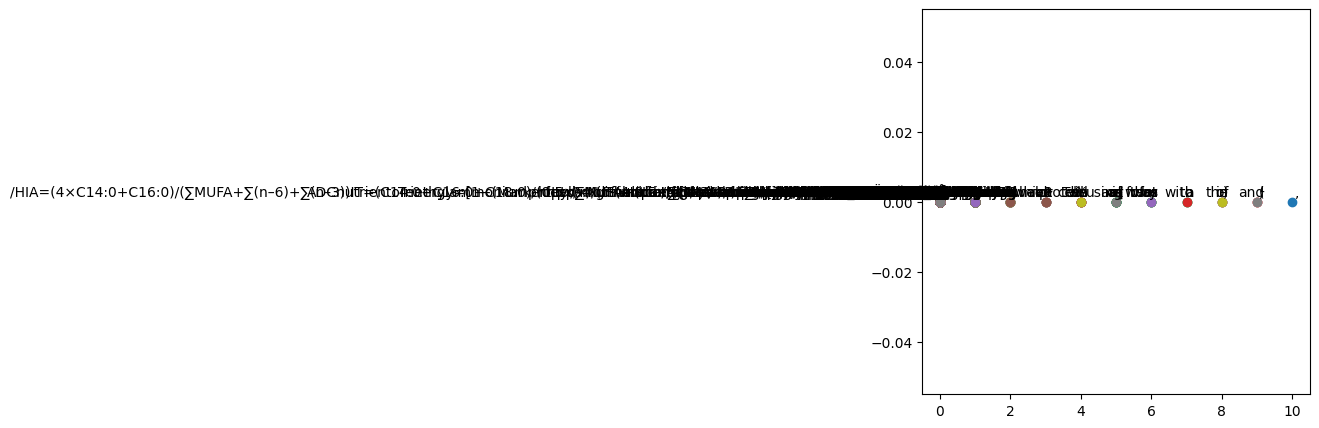

In [75]:
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib import pyplot as plt

# print(model.wv.get_vector("Gothenburg").tolist())
words = list(model.wv.index_to_key)
# print(words)

vectors = []
for word in words:
    vectors.append(model.wv.get_vector(word).tolist())

pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

# prepare a dataframe

words = pd.DataFrame(words)

PCA_result = pd.DataFrame(PCA_result)

PCA_result['x_values'] =PCA_result.iloc[0:, 0]

PCA_result['y_values'] =PCA_result.iloc[0:, 1]

PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)

PCA_final['word'] =PCA_final.iloc[0:, 0]

PCA_data_complet =PCA_final[['word','x_values','y_values']]

# PCA_data_complet

# visualise cluster
# can visualise, but NOT WELL
# plt.figure(figsize=(5,5))
# for row in PCA_data_complet.iterrows():
#     plt.scatter(int(row[1]["x_values"]), int(row[1]["y_values"]))
#     plt.annotate(row[1]["word"], xy=(int(row[1]["x_values"]), int(row[1]["y_values"])), xytext=(5,2), textcoords="offset points", ha="right", va="bottom")
# plt.show()

In [55]:
words = list(model.wv.index_to_key)
vectors = []
for word in words:
    vectors.append(model.wv.get_vector(word).tolist())

words = ["good", "this", "post", "another", "learning", "last", "the", "and", "more", "new", "is", "one", "about", "machine", "book"]

from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(words, assign_clusters=True)
print (assigned_clusters)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('<U7')) -> None